In [11]:
import torch
import torch.nn as nn
import onnx
import os, re, numpy as np
from pathlib import Path

In [12]:
# ONNX_PATH       = "trans1.onnx"     # <— change 
N_SAMPLES       = 10
OUT_DIR_TXT     = Path("./cal")
OUT_DIR_SAMPLES = Path("./cal_npy")
DATASET_TXT     = OUT_DIR_TXT / "dataset.txt"

## test models layers

In [13]:
class TestModel1(nn.Module):
    def __init__(self, ):
        super(TestModel1, self).__init__()

    def forward(self, x):        
        # Transpose [0,1,2,3]    => [0,1,3,2]
        #           [N, C, H, W] => [N, C, W, H]
        return x.permute(0, 1, 3, 2)
    
    
    
## TP_Fold_Conv
class TestModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 4, kernel_size=3, padding=1, bias=False)

    def forward(self, x):                   # x: [N,2,H,W]
        x = x.permute(0, 2, 3, 1)          # NCHW -> NHWC
        x = x.permute(0, 3, 1, 2)          # NHWC -> NCHW (so Conv2d can consume)
        return self.conv(x)                 # Conv runs on NPU; transposes fold away

## help functions


In [14]:
def export_to_onnx(model, dummy_input ,onnx_name):

    model.eval()
    y = model(dummy_input)
    print("input shape:", dummy_input.shape)
    print("output shape:", y.shape)

    #  fixed-length segments 
    torch.onnx.export(
        model,
        dummy_input,
        onnx_name,
        # input_names=["log_mel"],
        # output_names=["embedding"],
        opset_version=11
    )
    print("Exported to", onnx_name)

In [15]:
def load_onnx_inputs(path):
    model = onnx.load(path)
    g = model.graph
    initializer_names = {init.name for init in g.initializer}
    inputs = []
    for inp in g.input:
        if inp.name in initializer_names:
            continue  # skip weights
        shp = []
        if hasattr(inp.type, "tensor_type") and inp.type.tensor_type.HasField("shape"):
            for d in inp.type.tensor_type.shape.dim:
                if d.dim_value > 0:
                    shp.append(int(d.dim_value))
                else:
                    shp.append(None)  # dynamic
        inputs.append((inp.name, shp))
    return inputs

def coalesce_shapes(onnx_inputs, overrides):
    names, shapes = [], []
    for name, shp in onnx_inputs:
        if name in overrides:
            final = list(overrides[name])
        else:
            # replace dynamic/unknown with 1
            final = [d if (isinstance(d, int) and d > 0) else 1 for d in (shp or [])]
            if not final:
                raise ValueError(
                    f"Input '{name}' has no shape in ONNX; please set INPUT_OVERRIDES['{name}'] = [dims...]"
                )
        names.append(name)
        shapes.append(final)
    # allow overrides for extra inputs not found (rare)
    for extra, dims in overrides.items():
        if extra not in names:
            names.append(extra)
            shapes.append(list(dims))
    return names, shapes

def safe_name(s):
    # keep filenames simple (no spaces)
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', s)

## run

In [16]:
model1 = TestModel1()
model1.eval()

# Dummy input shape [N, C, H, W] e.g. [1, 2, 3, 4]
x = torch.randn(1, 2, 3, 4)
export_to_onnx(model1, x, "trans1.onnx")


input shape: torch.Size([1, 2, 3, 4])
output shape: torch.Size([1, 2, 4, 3])
Exported to trans1.onnx


In [17]:
model2 = TestModel2()
model2.eval()

# Dummy input shape [N, C, H, W] e.g. [1, 2, 3, 4]
x = torch.randn(1, 2, 3, 4)
export_to_onnx(model2, x, "trans2.onnx")

input shape: torch.Size([1, 2, 3, 4])
output shape: torch.Size([1, 4, 3, 4])
Exported to trans2.onnx


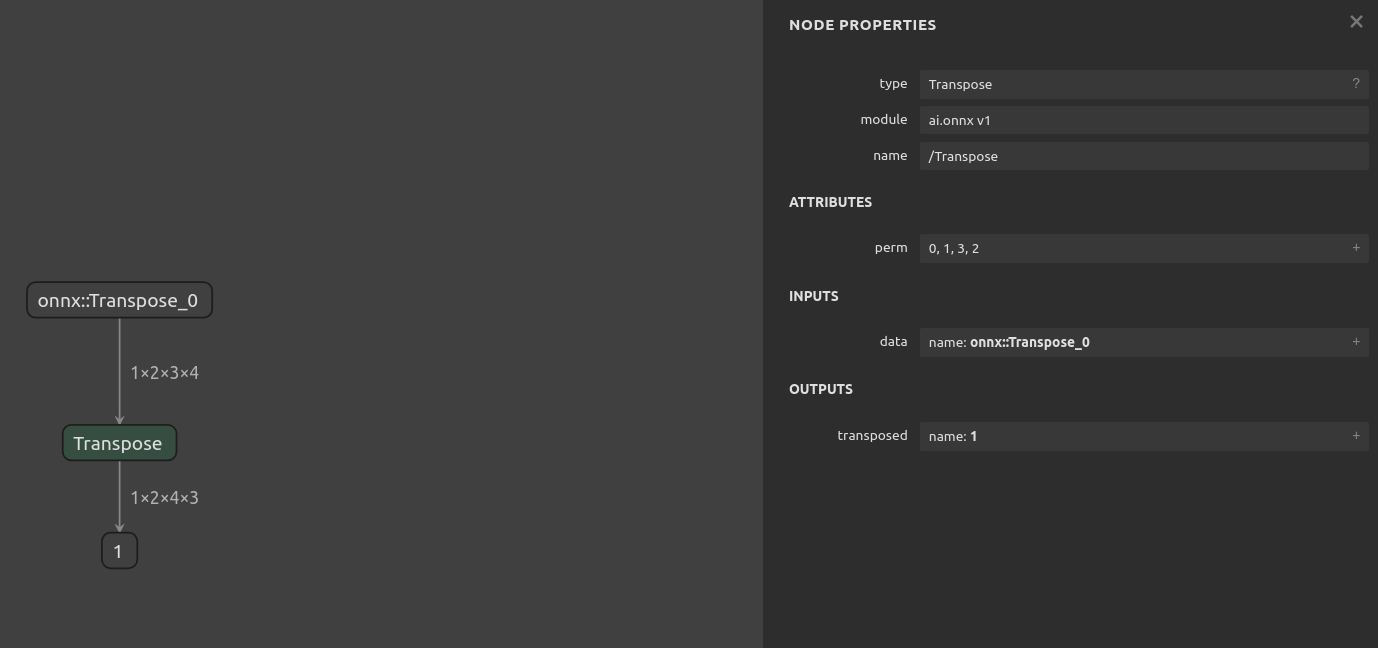

In [18]:
onnx_model = onnx.load("trans1.onnx")
print(onnx.helper.printable_graph(onnx_model.graph))


graph main_graph (
  %onnx::Transpose_0[FLOAT, 1x2x3x4]
) {
  %1 = Transpose[perm = [0, 1, 3, 2]](%onnx::Transpose_0)
  return %1
}


### cal

In [19]:
# Format: name -> [D0, D1, ...] (include batch dim; usually set to 1)
INPUT_OVERRIDES = {
    # "input": [1, 3, 224, 224],   # example for an image model (NCHW)
    # "tokens": [1, 128],          # example for a text input
}

In [20]:
def make_random_sample(shape, dtype=np.float32):
    # You can tweak this if your model expects uint8
    return np.random.randn(*shape).astype(dtype)


# 1) Resolve input names & shapes
onnx_inputs = load_onnx_inputs("trans1.onnx")
input_names, input_shapes = coalesce_shapes(onnx_inputs, INPUT_OVERRIDES)

print("Inputs for calibration:")
for n, s in zip(input_names, input_shapes):
    print(f"  • {n}: {s}")

# 2) Create dirs
OUT_DIR_TXT.mkdir(parents=True, exist_ok=True)
inner_folder = OUT_DIR_TXT/OUT_DIR_SAMPLES
inner_folder.mkdir(parents=True, exist_ok=True)

# 3) Generate npy files and dataset.txt
lines = []
for i in range(N_SAMPLES):
    sample_paths = []
    for n, s in zip(input_names, input_shapes):
        arr = make_random_sample(s, np.float32)
        fname = OUT_DIR_TXT/OUT_DIR_SAMPLES / f"{i:03d}_{safe_name(n)}.npy"
        fname_name = OUT_DIR_SAMPLES / f"{i:03d}_{safe_name(n)}.npy"
        np.save(fname, arr)
        sample_paths.append(str(fname_name))
    # For multi-input, RKNN expects one line with *space-separated* paths (order matters)
    lines.append(" ".join(sample_paths))

with open(DATASET_TXT, "w") as f:
    f.write("\n".join(lines) + "\n")

print(f"\nWrote {len(lines)} samples to: {OUT_DIR_SAMPLES}")
print(f"dataset.txt → {DATASET_TXT}")
print("\nFirst 3 lines:")
print("\n".join(lines[:3]))

Inputs for calibration:
  • onnx::Transpose_0: [1, 2, 3, 4]

Wrote 10 samples to: cal_npy
dataset.txt → cal/dataset.txt

First 3 lines:
cal_npy/000_onnx_Transpose_0.npy
cal_npy/001_onnx_Transpose_0.npy
cal_npy/002_onnx_Transpose_0.npy
